In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.metrics import f1_score, jaccard_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Drive'dan bağlantı (eğer veri oradaysa)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Dataset dizini (kendi yoluna göre değiştir)
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

# Görüntü yükleme fonksiyonu
def load_images_from_folder(folder_path, size=(256, 256)):
    image_paths = sorted(glob(os.path.join(folder_path, '*.jpg')))  # veya jpg
    images = []
    for path in image_paths:
        img = load_img(path, target_size=size, color_mode='grayscale')
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

# Eğitim verisi (sadece good)
train_images = load_images_from_folder(os.path.join(DATASET_DIR, 'train/good'))

# Test verisi (good + defect)
test_good = load_images_from_folder(os.path.join(DATASET_DIR, 'test/good'))
test_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'test/defect'))

# Maskeler (IoU için)
mask_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Şekil kontrolü
print(f"Train: {train_images.shape}, Test_good: {test_good.shape}, Test_defect: {test_defect.shape}")

Train: (70, 256, 256, 1), Test_good: (70, 256, 256, 1), Test_defect: (71, 256, 256, 1)


In [3]:
X_train, X_val = train_test_split(
    train_images,
    test_size=0.1,  # %10 validation
    shuffle=True,   # Mutlaka karıştır
    random_state=42 # Tekrarlanabilirlik için
)

In [4]:
def build_advanced_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return autoencoder

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5
)

In [6]:
# Gelişmiş Autoencoder
autoencoder = build_advanced_autoencoder((256, 256, 1))
autoencoder.summary()

# Eğitim
history = autoencoder.fit(
    train_datagen.flow(X_train, X_train, batch_size=16),
    validation_data=(X_val, X_val),
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.0500 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0402 - val_loss: 0.0366 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0367 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0368 - val_loss: 0.0335 - learning_rate: 1.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0359 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0348 - val_loss: 0.0334 - learning_rate: 1.0000e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.0371 - val_loss: 0.0316 - learning_rate: 1.0000e-04
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0344 - val_loss: 0.0306 - learning_rate: 1.0000e-04
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0345 - val_loss: 0.0298 - learning_ra

In [7]:
# Gelişmiş Anomali Skoru Hesaplama
def compute_advanced_anomaly_score(original, reconstructed):
    # Çoklu metrik anomali skoru
    pixel_diff = np.mean(np.abs(original - reconstructed), axis=(1,2,3))
    global_diff = np.max(np.abs(original - reconstructed), axis=(1,2,3))
    variance_diff = np.var(np.abs(original - reconstructed), axis=(1,2,3))
    return (pixel_diff + global_diff + variance_diff) / 3

# Test görüntüleri
test_all = np.concatenate([test_good, test_defect])
reconstructed = autoencoder.predict(test_all)

# Anomali Skorları
scores = compute_advanced_anomaly_score(test_all, reconstructed)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 523ms/step


In [8]:
# ROC Eğrisi ile Optimal Eşik
true_labels = np.array([0]*len(test_good) + [1]*len(test_defect))
fpr, tpr, thresholds = roc_curve(true_labels, scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tahmin Etiketleri
pred_labels = (scores > optimal_threshold).astype(int)

# Performans Metrikleri
f1 = f1_score(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

print("Optimal Threshold:", optimal_threshold)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Optimal Threshold: 0.1729563
F1 Score: 0.8152866242038217
ROC AUC: 0.8321931589537223


In [9]:
# Segmentasyon ve IoU Hesaplama
def get_binary_mask(original, reconstructed, threshold):
    diff = np.abs(original - reconstructed)
    mask = (diff > threshold).astype(np.uint8)
    return mask

# IoU Hesaplama
ious = []
threshold_pixel = 0.1  # piksel bazlı eşik

for i in range(len(test_defect)):
    if i < len(mask_defect):
        pred_mask = get_binary_mask(test_defect[i:i+1], reconstructed[len(test_good)+i:len(test_good)+i+1], threshold_pixel)[0]
        gt_mask = (mask_defect[i] > 0.1).astype(np.uint8)

        iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())
        ious.append(iou)

print("Mean IoU:", np.mean(ious))

Mean IoU: 0.08272867200883008


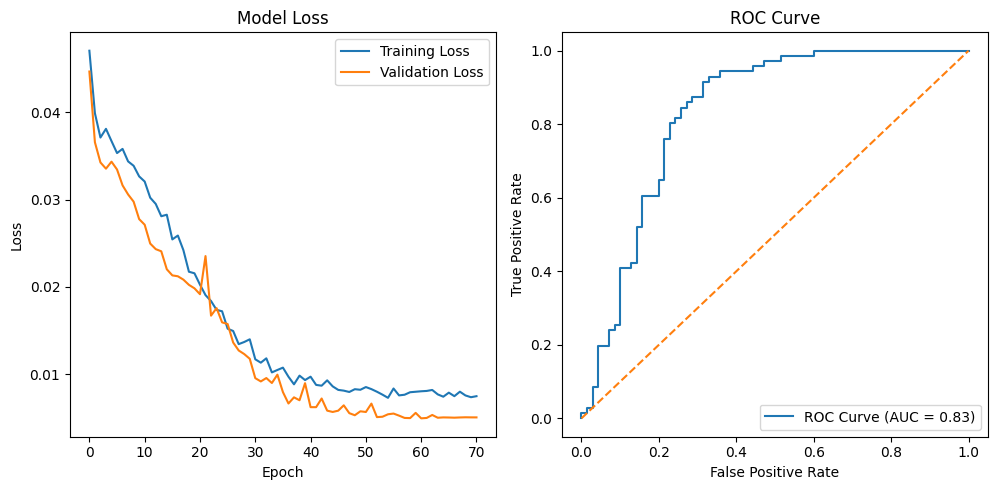

In [10]:
# Görselleştirme
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

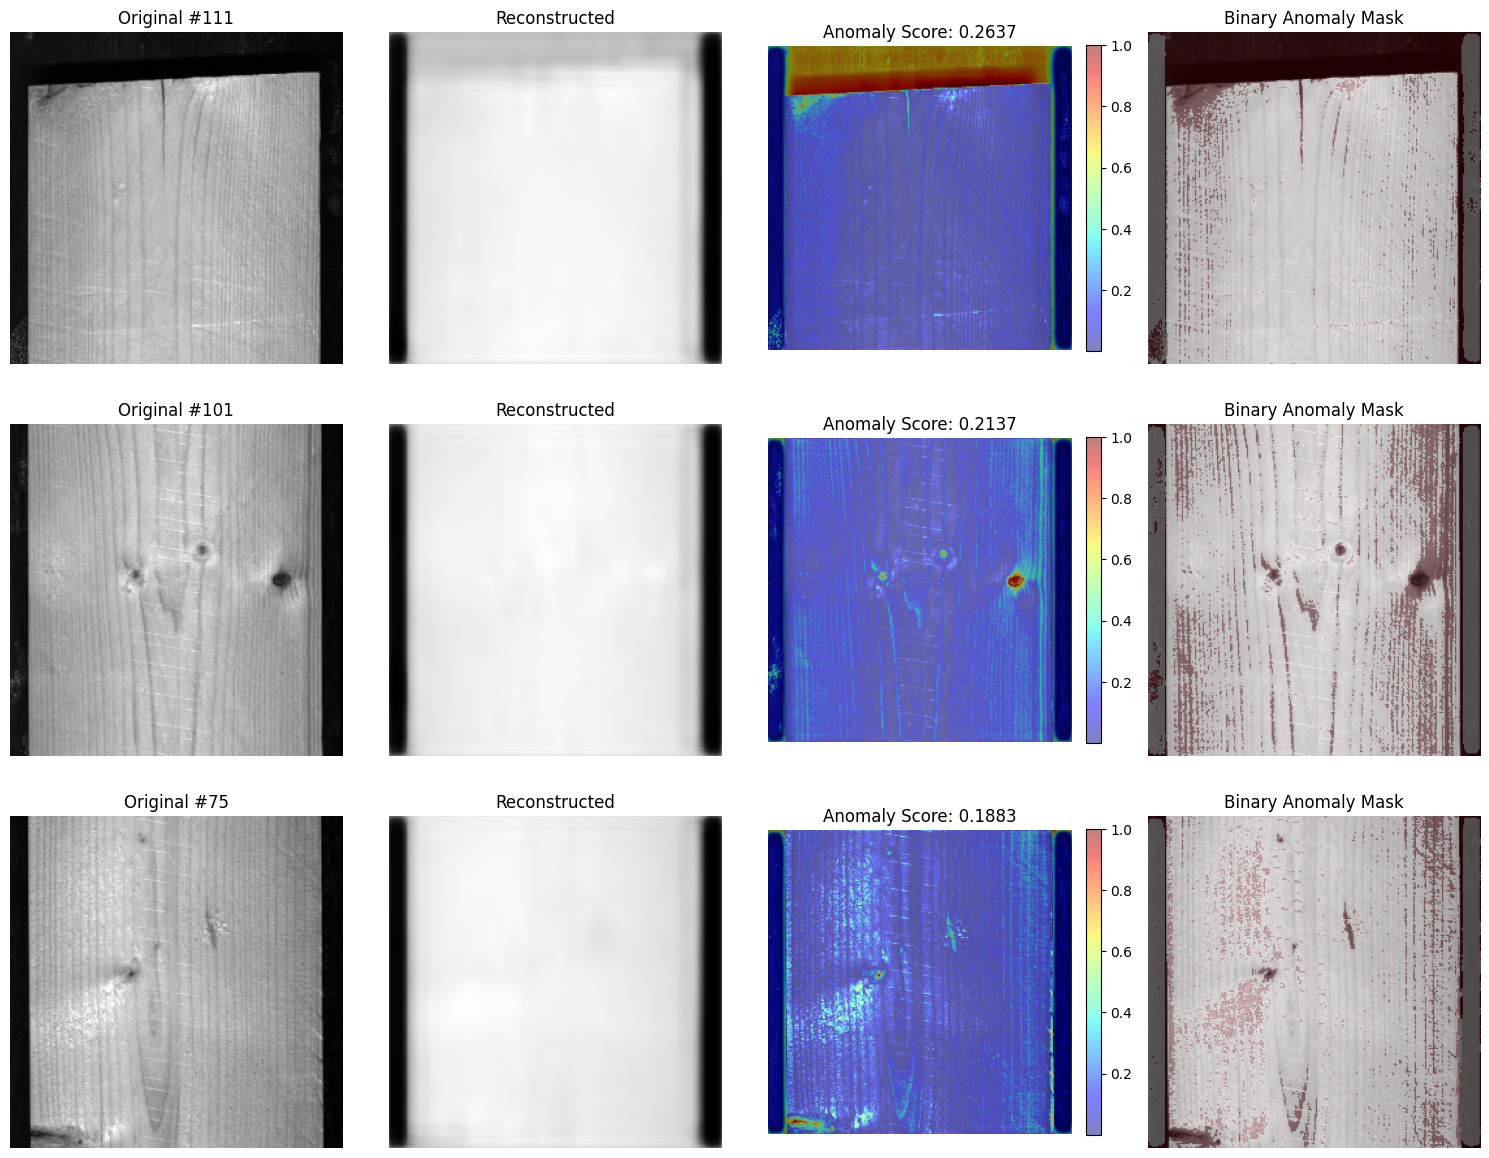

In [11]:
# Advanced Anomaly Visualization with Colormap
def visualize_detailed_anomaly(original_images, reconstructed_images,
                              idx_list=None, threshold=None):
    """
    Detailed visualization showing original, reconstruction, anomaly heatmap and binary detection

    Args:
        original_images: Original test images
        reconstructed_images: Reconstructed images from autoencoder
        idx_list: List of image indices to display (default: picks random defect samples)
        threshold: Threshold for binary anomaly detection (default: uses optimal_threshold)
    """
    if idx_list is None:
        # Choose random defect examples if not specified
        idx_list = np.random.choice(np.arange(len(test_good), len(test_all)),
                                    size=min(3, len(test_defect)), replace=False)

    if threshold is None:
        threshold = optimal_threshold

    n = len(idx_list)
    plt.figure(figsize=(15, 4*n))

    for i, idx in enumerate(idx_list):
        original = original_images[idx]
        reconstructed = reconstructed_images[idx]

        # Calculate difference and normalize for better visualization
        diff = np.abs(original - reconstructed)
        diff_normalized = diff / np.max(diff)

        binary_mask = (diff > threshold_pixel).astype(np.uint8)

        # Original
        plt.subplot(n, 4, i*4+1)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.title(f'Original #{idx}')
        plt.axis('off')

        # Reconstructed
        plt.subplot(n, 4, i*4+2)
        plt.imshow(reconstructed.squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        # Heatmap Overlay
        plt.subplot(n, 4, i*4+3)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.5)
        plt.title(f'Anomaly Score: {scores[idx]:.4f}')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        # Binary Anomaly Mask
        plt.subplot(n, 4, i*4+4)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.imshow(binary_mask.squeeze(), cmap='Reds', alpha=0.3)
        plt.title('Binary Anomaly Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize several defect samples with detailed analysis
defect_indices = np.random.choice(np.arange(len(test_good), len(test_all)),
                                 size=min(3, len(test_defect)), replace=False)

visualize_detailed_anomaly(test_all, reconstructed, idx_list=defect_indices)

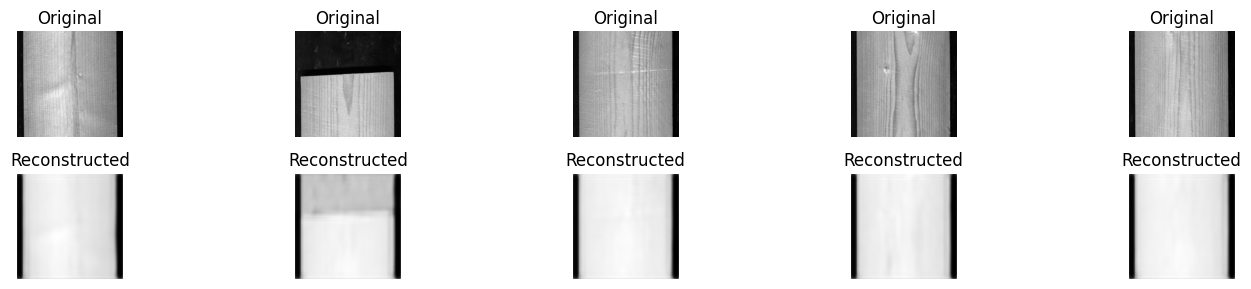

In [12]:
# Örnek Görüntüleme (Orijinal koddan)
def plot_reconstruction(original, reconstructed, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        # Orijinal
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstruct
        plt.subplot(2, n, n+i+1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# İlk 5 test görüntüsü için rekonstrüksiyon
plot_reconstruction(test_all[:5], reconstructed[:5])

Good samples:


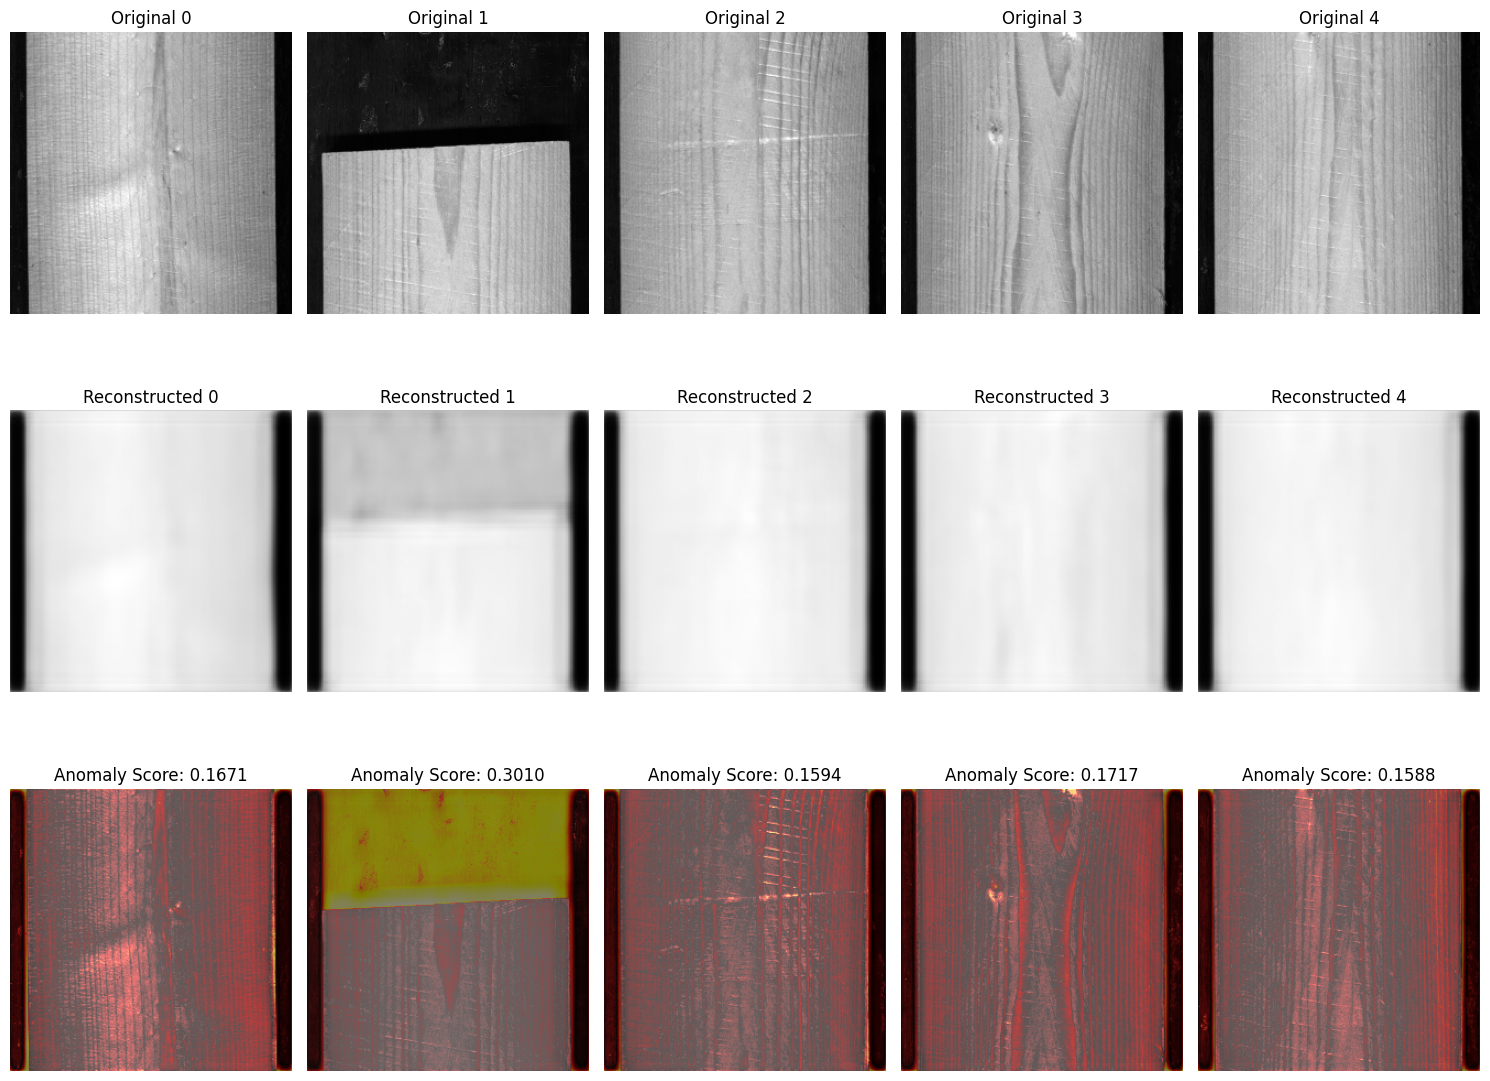

Defect samples:


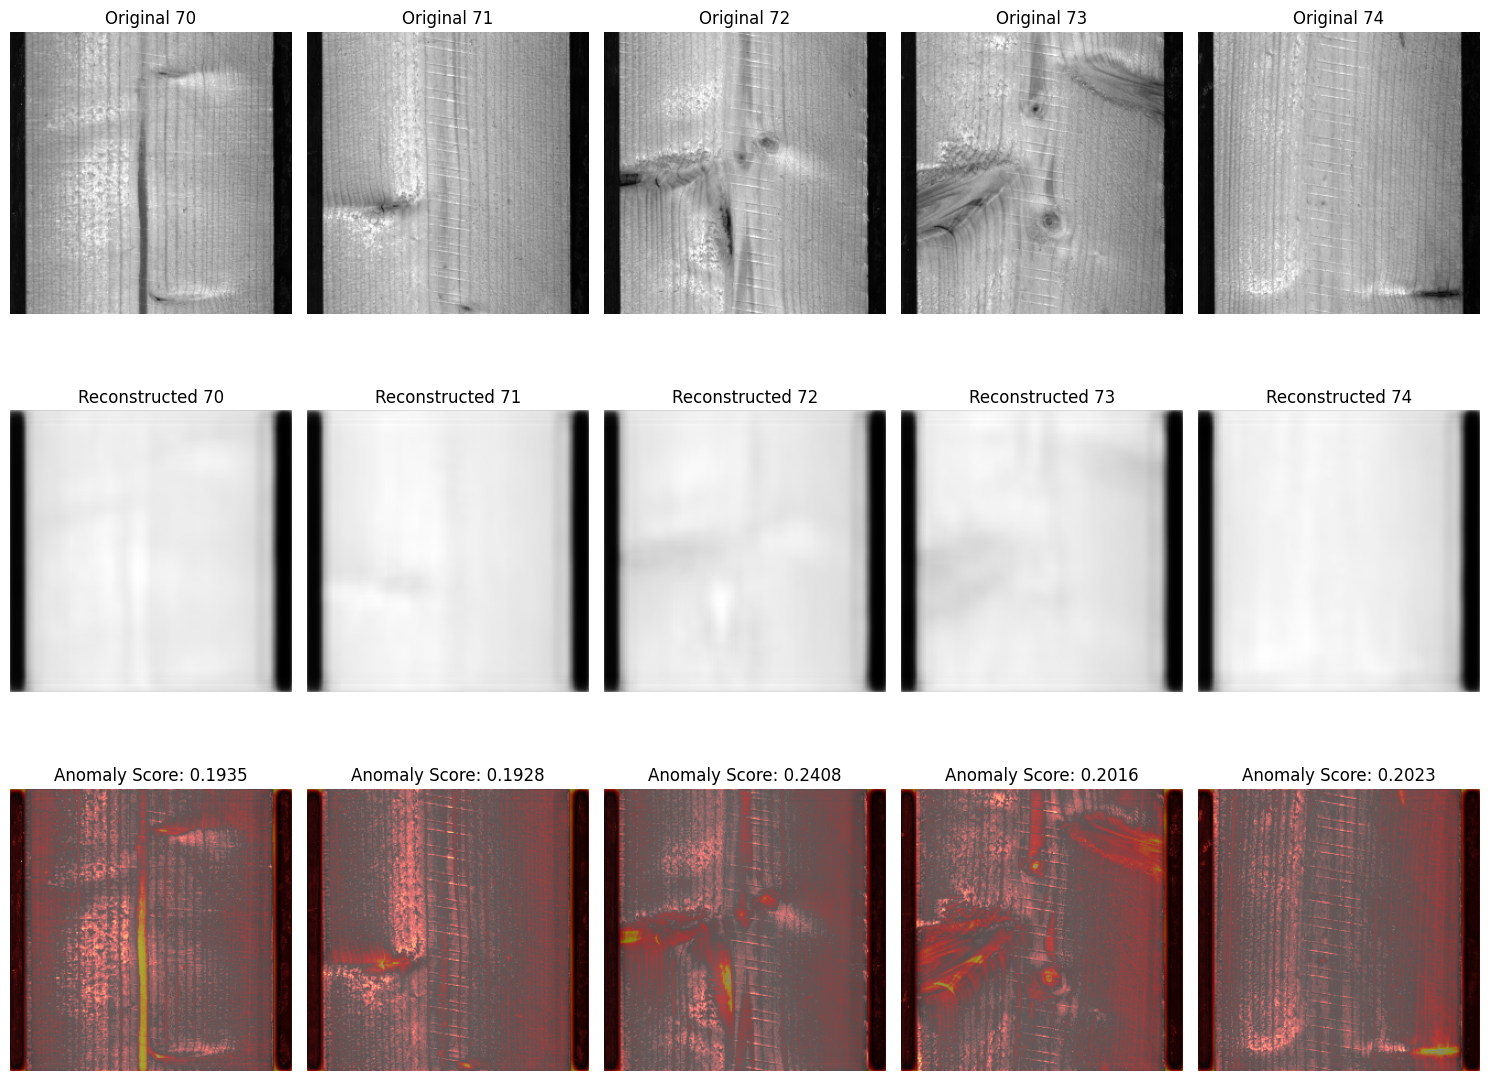

In [13]:
# Anomaly Detection Heatmap Visualization
def visualize_anomaly_with_heatmap(original_images, reconstructed_images, num_samples=5, start_idx=0):
    plt.figure(figsize=(15, 12))

    for i in range(num_samples):
        idx = start_idx + i
        if idx >= len(original_images):
            break

        original = original_images[idx]
        reconstructed = reconstructed_images[idx]

        # Calculate difference/anomaly map
        diff = np.abs(original - reconstructed)

        # Row 1: Original Image
        plt.subplot(3, num_samples, i+1)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.title(f'Original {idx}')
        plt.axis('off')

        # Row 2: Reconstructed Image
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(reconstructed.squeeze(), cmap='gray')
        plt.title(f'Reconstructed {idx}')
        plt.axis('off')

        # Row 3: Anomaly Heatmap
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.imshow(diff.squeeze(), cmap='hot', alpha=0.5)  # Overlay heatmap with transparency
        plt.title(f'Anomaly Score: {scores[idx]:.4f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize good samples (should have low anomaly scores)
print("Good samples:")
visualize_anomaly_with_heatmap(test_all, reconstructed, num_samples=5, start_idx=0)

# Visualize defect samples (should have high anomaly scores)
print("Defect samples:")
visualize_anomaly_with_heatmap(test_all, reconstructed, num_samples=5, start_idx=len(test_good))

Anomaly Detection on Good Samples:
Min Score: 0.1560, Max Score: 0.3010, Mean Score: 0.1780


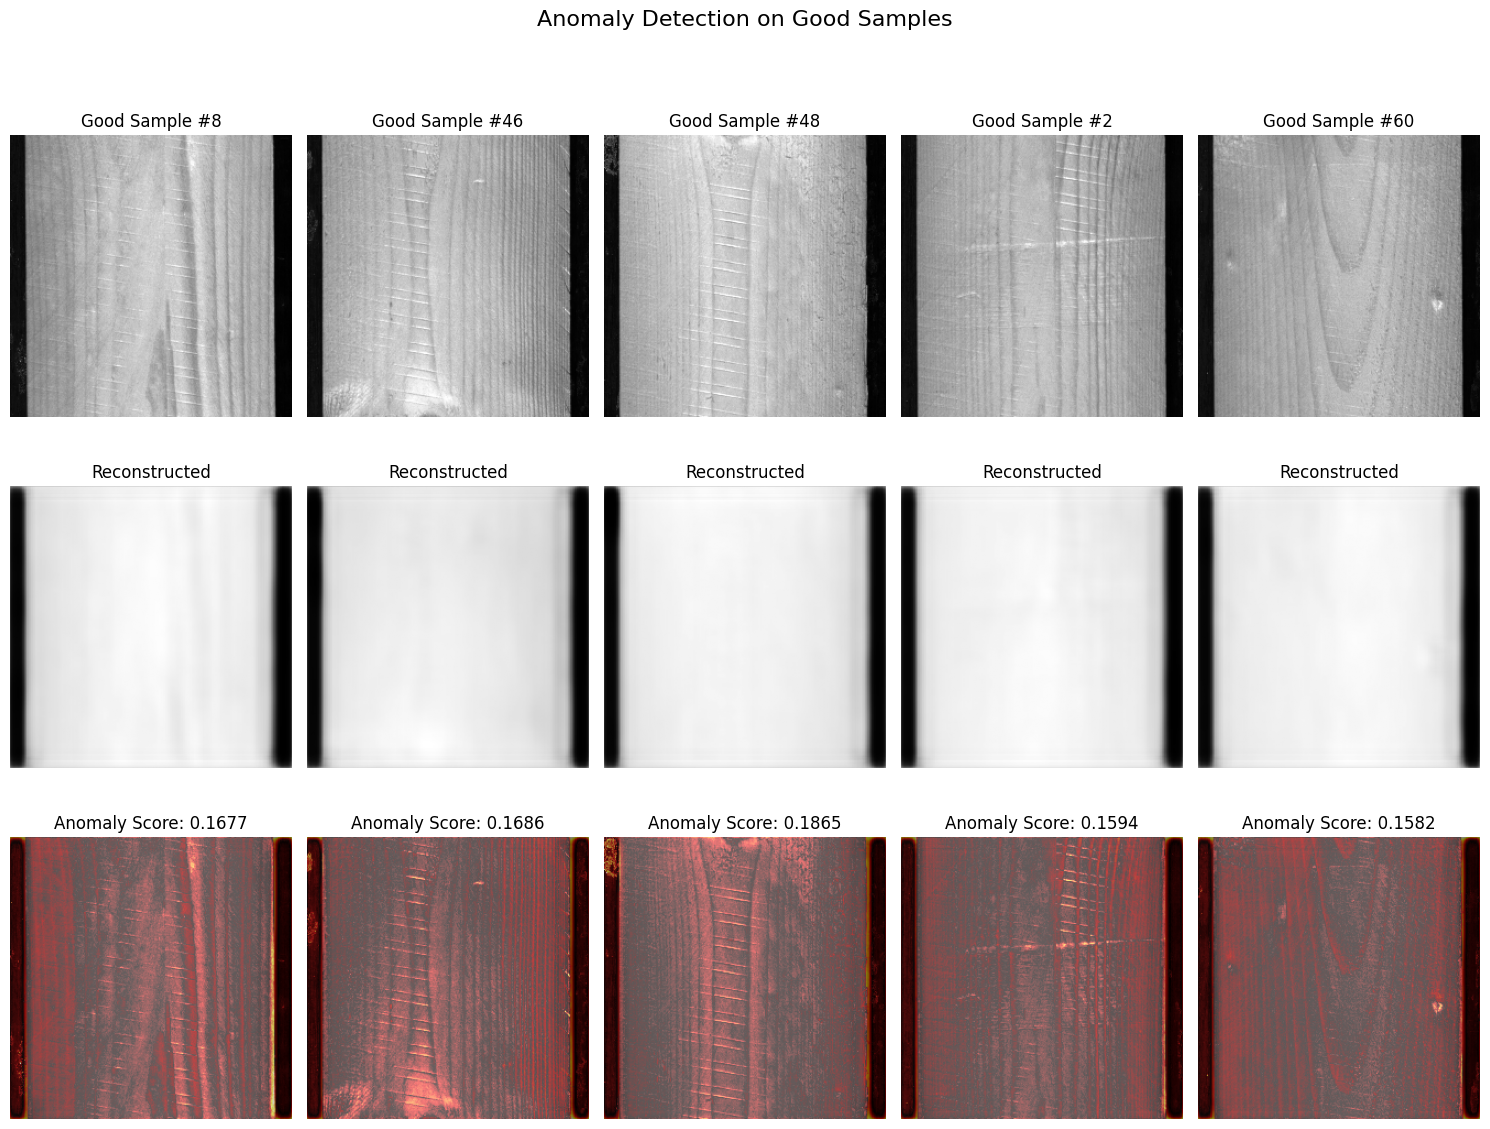

In [14]:
# Anomaly Detection Heatmap for Good Samples
def visualize_good_samples_heatmap(test_good_images, reconstructed_good_images, scores, num_samples=5):
    """
    Visualize anomaly detection with heatmaps specifically for good samples

    Args:
        test_good_images: Original test good images
        reconstructed_good_images: Reconstructed good images from autoencoder
        scores: Anomaly scores for the images
        num_samples: Number of samples to visualize
    """
    # Choose random indices or show the first few if less than num_samples
    if len(test_good_images) <= num_samples:
        indices = range(len(test_good_images))
    else:
        indices = np.random.choice(len(test_good_images), size=num_samples, replace=False)

    plt.figure(figsize=(15, 12))

    for i, idx in enumerate(indices):
        original = test_good_images[idx]
        reconstructed = reconstructed_good_images[idx]

        # Calculate difference and normalize for better visualization
        diff = np.abs(original - reconstructed)
        diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

        # Original
        plt.subplot(3, num_samples, i+1)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.title(f'Good Sample #{idx}')
        plt.axis('off')

        # Reconstructed
        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(reconstructed.squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

        # Heatmap Overlay
        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.imshow(diff_normalized.squeeze(), cmap='hot', alpha=0.5)
        plt.title(f'Anomaly Score: {scores[idx]:.4f}')
        plt.axis('off')

    plt.suptitle('Anomaly Detection on Good Samples', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    plt.show()

# Get reconstructions specifically for the good samples
reconstructed_good = reconstructed[:len(test_good)]
# Get scores for good samples
good_scores = scores[:len(test_good)]

print("Anomaly Detection on Good Samples:")
print(f"Min Score: {np.min(good_scores):.4f}, Max Score: {np.max(good_scores):.4f}, Mean Score: {np.mean(good_scores):.4f}")
visualize_good_samples_heatmap(test_good, reconstructed_good, good_scores, num_samples=5)

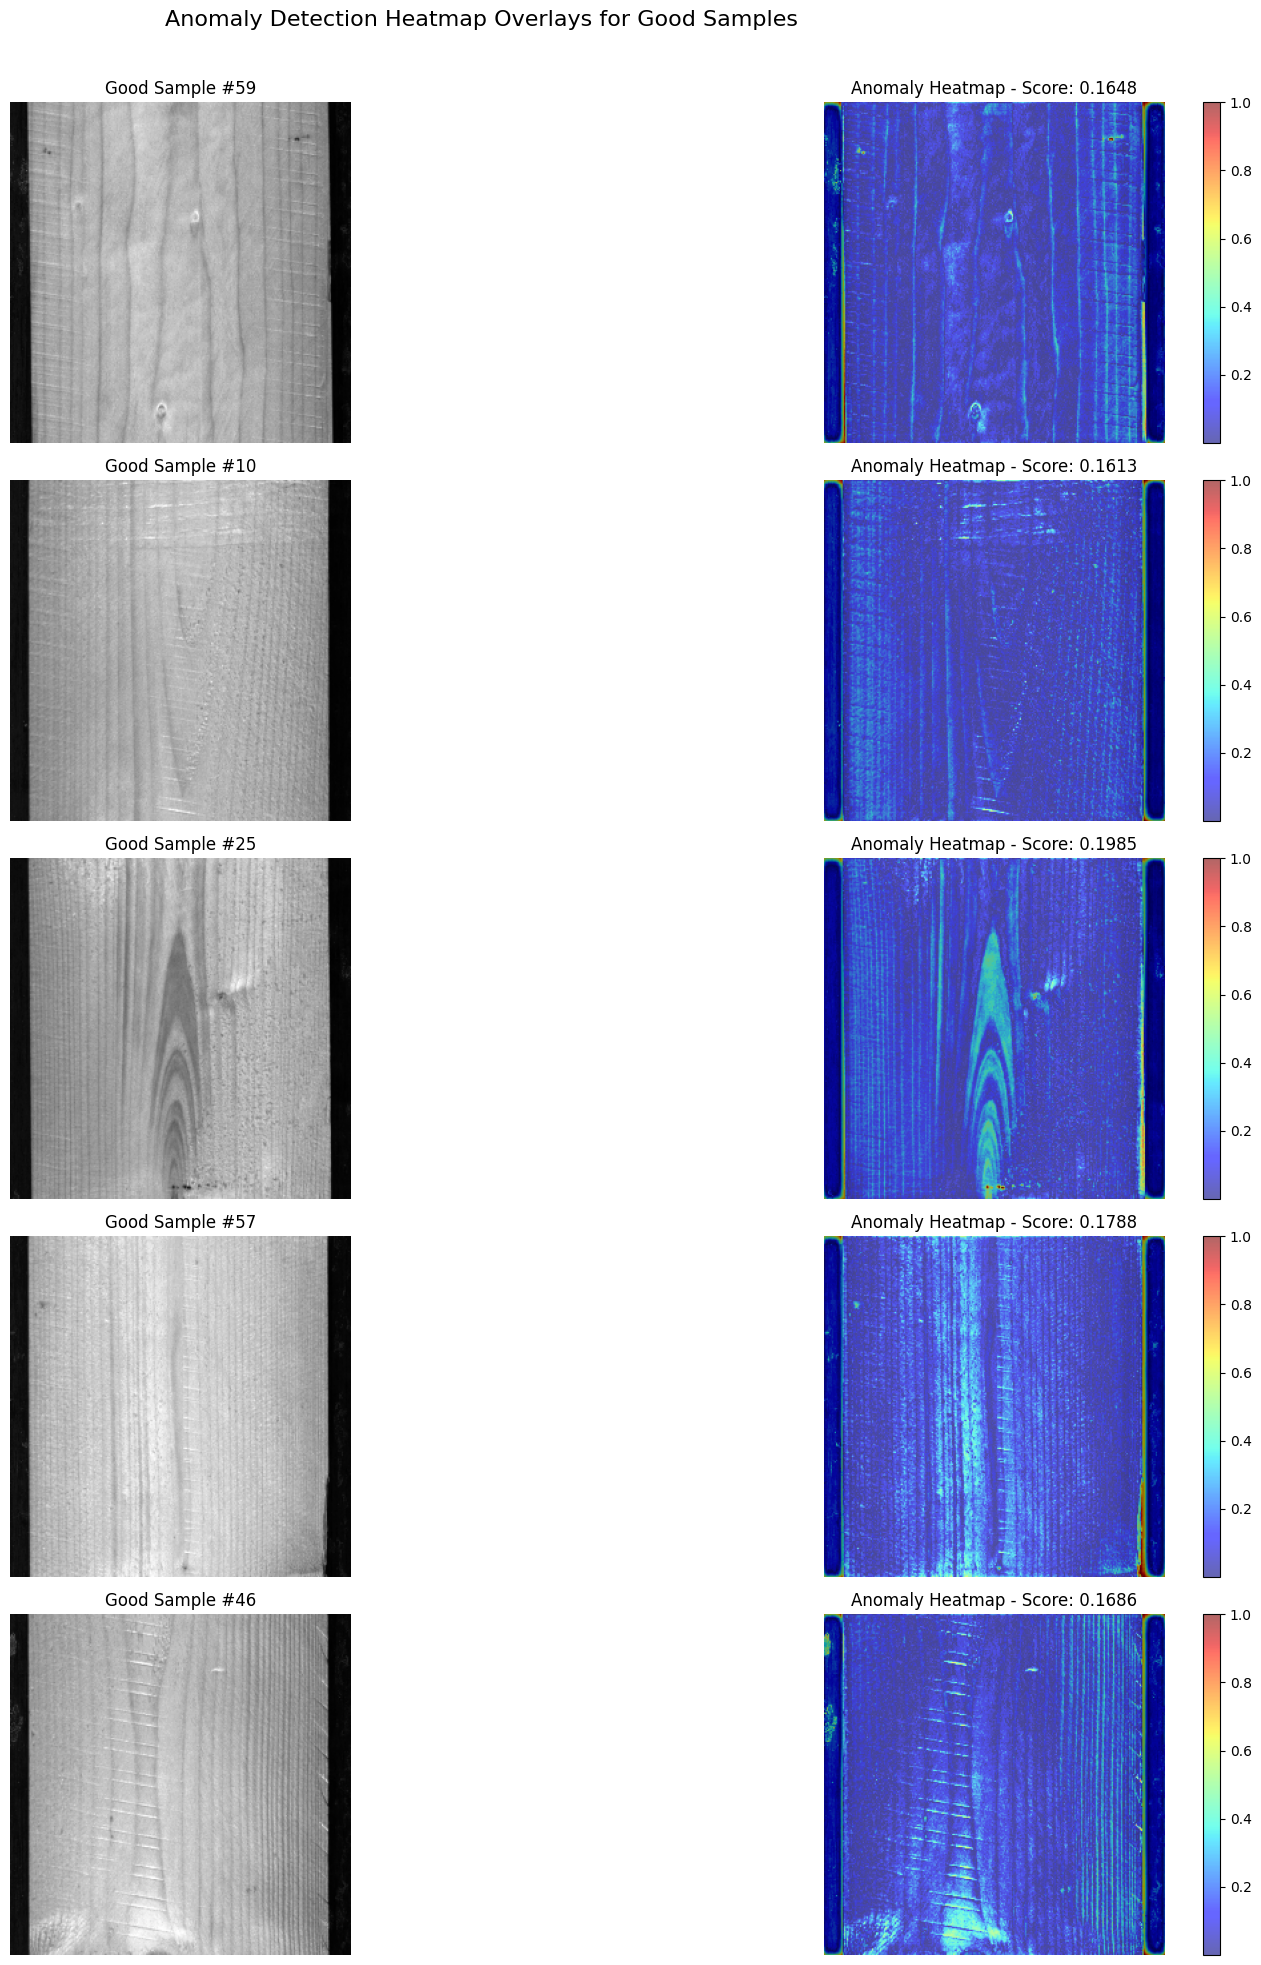

In [15]:
# Heatmap Overlay for Good Images Anomaly Detection
def visualize_good_images_anomaly_heatmap(test_good_images, reconstructed_good_images, num_samples=5):
    """
    Creates heatmap overlays specifically for good samples showing where the model detects anomalies
    """
    # Choose random indices or use all if less than num_samples
    if len(test_good_images) <= num_samples:
        indices = range(len(test_good_images))
    else:
        indices = np.random.choice(len(test_good_images), size=num_samples, replace=False)

    plt.figure(figsize=(16, 4*len(indices)))

    for i, idx in enumerate(indices):
        original = test_good_images[idx]
        reconstructed = reconstructed_good_images[idx]

        # Calculate difference for anomaly detection
        diff = np.abs(original - reconstructed)

        # Normalize the difference for better visualization
        if np.max(diff) > 0:
            diff_normalized = diff / np.max(diff)
        else:
            diff_normalized = diff

        # Plot side by side: Original and Heatmap Overlay
        plt.subplot(len(indices), 2, 2*i+1)
        plt.imshow(original.squeeze(), cmap='gray')
        plt.title(f'Good Sample #{idx}')
        plt.axis('off')

        # Create heatmap overlay
        plt.subplot(len(indices), 2, 2*i+2)
        plt.imshow(original.squeeze(), cmap='gray')
        heatmap = plt.imshow(diff_normalized.squeeze(), cmap='jet', alpha=0.6)
        plt.colorbar(heatmap, fraction=0.046, pad=0.04)
        plt.title(f'Anomaly Heatmap - Score: {scores[idx]:.4f}')
        plt.axis('off')

    plt.suptitle('Anomaly Detection Heatmap Overlays for Good Samples', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Get reconstructions specifically for the good samples
reconstructed_good = reconstructed[:len(test_good)]

# Visualize the heatmaps
visualize_good_images_anomaly_heatmap(test_good, reconstructed_good, num_samples=5)

In [16]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions based on optimal threshold
predictions = (scores > optimal_threshold).astype(int)
true_labels = np.array([0]*len(test_good) + [1]*len(test_defect))

# Create results dataframe
results_df = pd.DataFrame({
    'Image_Index': range(len(test_all)),
    'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
    'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
    'Anomaly_Score': scores,
    'Is_Correct': true_labels == predictions
})

# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions,
                                     target_names=['Good', 'Defect'],
                                     output_dict=True)

# Generate confusion matrix figure
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Defect'],
            yticklabels=['Good', 'Defect'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Save confusion matrix to bytes for embedding in HTML
conf_matrix_img = BytesIO()
plt.tight_layout()
plt.savefig(conf_matrix_img, format='png')
plt.close()
conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

# Generate ROC curve figure
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Save ROC curve to bytes for embedding in HTML
roc_img = BytesIO()
plt.tight_layout()
plt.savefig(roc_img, format='png')
plt.close()
roc_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

# Generate score distribution figure
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Anomaly_Score', hue='True_Label',
             bins=30, kde=True, element='step')
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
            label=f'Threshold = {optimal_threshold:.4f}')
plt.legend()
plt.title('Anomaly Score Distribution')

# Save distribution figure to bytes for embedding in HTML
dist_img = BytesIO()
plt.tight_layout()
plt.savefig(dist_img, format='png')
plt.close()
dist_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

# Let's use the existing image visualization functions that work
example_images = []
# Use fewer examples if needed
num_good_examples = min(2, len(test_good))
num_defect_examples = min(2, len(test_defect))

# Generate good example visualizations
for i in range(num_good_examples):
    idx = i  # Use first few good examples
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot - Original Good Image
    axes[0].imshow(test_good[i].reshape(256, 256), cmap='gray')
    axes[0].set_title(f'Original Good Image #{i}')
    axes[0].axis('off')

    # Second subplot - Anomaly Score
    axes[1].text(0.5, 0.5, f'Anomaly Score: {scores[idx]:.4f}\nClassified as: {"Good" if predictions[idx]==0 else "Defect"}',
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[1].transAxes, fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    plt.close(fig)
    img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

    example_images.append({
        'image': img_b64,
        'index': idx,
        'true_class': 'Good',
        'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
        'is_correct': predictions[idx] == 0,
        'score': scores[idx]
    })

# Generate defect example visualizations
for i in range(num_defect_examples):
    idx = len(test_good) + i  # Index for defect examples
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot - Original Defect Image
    axes[0].imshow(test_defect[i].reshape(256, 256), cmap='gray')
    axes[0].set_title(f'Original Defect Image #{i}')
    axes[0].axis('off')

    # Second subplot - Anomaly Score
    axes[1].text(0.5, 0.5, f'Anomaly Score: {scores[idx]:.4f}\nClassified as: {"Good" if predictions[idx]==0 else "Defect"}',
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[1].transAxes, fontsize=12)
    axes[1].axis('off')

    plt.tight_layout()

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    plt.close(fig)
    img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

    example_images.append({
        'image': img_b64,
        'index': idx,
        'true_class': 'Defect',
        'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
        'is_correct': predictions[idx] == 1,
        'score': scores[idx]
    })

# Create HTML report
html_content = f'''
<!DOCTYPE html>
<html>
<head>
    <title>Wood Defect Detection - Autoencoder Results</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        .container {{ max-width: 1200px; margin: 0 auto; }}
        .header {{ text-align: center; margin-bottom: 30px; }}
        .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; }}
        .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; }}
        .chart-container {{ margin-bottom: 30px; }}
        .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
        .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        .results-table th {{ background-color: #f2f2f2; }}
        .example-container {{ margin-bottom: 40px; }}
        .example-item {{ margin-bottom: 20px; }}
        .correct {{ color: green; }}
        .incorrect {{ color: red; }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>Wood Defect Detection Report</h1>
            <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        </div>

        <h2>Performance Summary</h2>
        <div class="metrics">
            <div class="metric-card">
                <h3>Accuracy</h3>
                <p>{(true_labels == predictions).mean():.4f}</p>
            </div>
            <div class="metric-card">
                <h3>F1 Score</h3>
                <p>{f1:.4f}</p>
            </div>
            <div class="metric-card">
                <h3>ROC AUC</h3>
                <p>{roc_auc:.4f}</p>
            </div>
            <div class="metric-card">
                <h3>Optimal Threshold</h3>
                <p>{optimal_threshold:.4f}</p>
            </div>
        </div>

        <div class="chart-container">
            <h2>Confusion Matrix</h2>
            <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
        </div>

        <div class="chart-container">
            <h2>ROC Curve</h2>
            <img src="data:image/png;base64,{roc_b64}" alt="ROC Curve" style="max-width:100%;">
        </div>

        <div class="chart-container">
            <h2>Anomaly Score Distribution</h2>
            <img src="data:image/png;base64,{dist_b64}" alt="Score Distribution" style="max-width:100%;">
        </div>

        <h2>Classification Results</h2>
        <table class="results-table">
            <tr>
                <th>Class</th>
                <th>Precision</th>
                <th>Recall</th>
                <th>F1-Score</th>
                <th>Support</th>
            </tr>
            <tr>
                <td>Good</td>
                <td>{class_report['Good']['precision']:.4f}</td>
                <td>{class_report['Good']['recall']:.4f}</td>
                <td>{class_report['Good']['f1-score']:.4f}</td>
                <td>{class_report['Good']['support']}</td>
            </tr>
            <tr>
                <td>Defect</td>
                <td>{class_report['Defect']['precision']:.4f}</td>
                <td>{class_report['Defect']['recall']:.4f}</td>
                <td>{class_report['Defect']['f1-score']:.4f}</td>
                <td>{class_report['Defect']['support']}</td>
            </tr>
        </table>

        <h2>Example Visualizations</h2>
        <div class="example-container">
'''

# Add example visualizations to HTML
for example in example_images:
    correct_class = 'correct' if example['is_correct'] else 'incorrect'
    html_content += f'''
            <div class="example-item">
                <h3>Image #{example['index']} -
                    <span>True: {example['true_class']}, </span>
                    <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                    <span>(Score: {example['score']:.4f})</span>
                </h3>
                <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
            </div>
    '''

html_content += '''
        </div>
    </div>
</body>
</html>
'''

# Save the HTML report to the data directory
report_path = os.path.join(DATASET_DIR, 'AE_summary_report.html')
with open(report_path, 'w') as f:
    f.write(html_content)

print(f"Classification report saved to: {report_path}")

# Output a summary of classification results
print("\nClassification Summary:")
print(f"Total Images: {len(test_all)}")
print(f"Good Images: {len(test_good)}, Defect Images: {len(test_defect)}")
print(f"Correctly Classified: {(true_labels == predictions).sum()} / {len(test_all)}")
print(f"Accuracy: {(true_labels == predictions).mean():.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Classification report saved to: /content/drive/MyDrive/wood_dataset/wood/AE_summary_report.html

Classification Summary:
Total Images: 141
Good Images: 70, Defect Images: 71
Correctly Classified: 112 / 141
Accuracy: 0.7943
F1 Score: 0.8153
ROC AUC: 0.8322


In [17]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import tensorflow as tf
import os
import numpy as np

# 1. Save only the model weights
weights_path = os.path.join(DATASET_DIR, 'autoencoder.weights.h5')
autoencoder.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")


Model weights saved to: /content/drive/MyDrive/wood_dataset/wood/autoencoder.weights.h5


In [18]:
import pandas as pd
from datetime import datetime
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# 1. Save only the model weights
weights_path = os.path.join(DATASET_DIR, 'autoencoder.weights.h5')
autoencoder.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

# 2. Define the same autoencoder architecture again
def build_advanced_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return autoencoder

# 3. Create a new model with the same architecture
loaded_model = build_advanced_autoencoder((256, 256, 1))

# 4. Load the weights into the new model
loaded_model.load_weights(weights_path)
print("Model weights loaded successfully")

# 5. Generate reconstructions with the loaded model
test_all = np.concatenate([test_good, test_defect])
reconstructed = loaded_model.predict(test_all)

# 6. Compute anomaly scores
def compute_advanced_anomaly_score(original, reconstructed):
    # Multiple metric anomaly score
    pixel_diff = np.mean(np.abs(original - reconstructed), axis=(1,2,3))
    global_diff = np.max(np.abs(original - reconstructed), axis=(1,2,3))
    variance_diff = np.var(np.abs(original - reconstructed), axis=(1,2,3))
    return (pixel_diff + global_diff + variance_diff) / 3

scores = compute_advanced_anomaly_score(test_all, reconstructed)

# 7. ROC analysis to find optimal threshold
true_labels = np.array([0]*len(test_good) + [1]*len(test_defect))
fpr, tpr, thresholds = roc_curve(true_labels, scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 8. F1 score and AUC calculation
pred_labels = (scores > optimal_threshold).astype(int)
f1 = f1_score(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

print("Using loaded model weights:")
print("Optimal Threshold:", optimal_threshold)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

# Get predictions based on optimal threshold
predictions = (scores > optimal_threshold).astype(int)

# Create results dataframe
results_df = pd.DataFrame({
    'Image_Index': range(len(test_all)),
    'True_Label': ['Good' if label == 0 else 'Defect' for label in true_labels],
    'Predicted_Label': ['Good' if pred == 0 else 'Defect' for pred in predictions],
    'Anomaly_Score': scores,
    'Is_Correct': true_labels == predictions
})

# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predictions)
class_report = classification_report(true_labels, predictions,
                                     target_names=['Good', 'Defect'],
                                     output_dict=True)

# Generate confusion matrix figure
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Defect'],
            yticklabels=['Good', 'Defect'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Save confusion matrix to bytes for embedding in HTML
conf_matrix_img = BytesIO()
plt.tight_layout()
plt.savefig(conf_matrix_img, format='png')
plt.close()
conf_matrix_b64 = base64.b64encode(conf_matrix_img.getvalue()).decode('utf-8')

# Generate ROC curve figure
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Save ROC curve to bytes for embedding in HTML
roc_img = BytesIO()
plt.tight_layout()
plt.savefig(roc_img, format='png')
plt.close()
roc_b64 = base64.b64encode(roc_img.getvalue()).decode('utf-8')

# Generate score distribution figure
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='Anomaly_Score', hue='True_Label',
             bins=30, kde=True, element='step')
plt.axvline(x=optimal_threshold, color='red', linestyle='--',
            label=f'Threshold = {optimal_threshold:.4f}')
plt.legend()
plt.title('Anomaly Score Distribution')

# Save distribution figure to bytes for embedding in HTML
dist_img = BytesIO()
plt.tight_layout()
plt.savefig(dist_img, format='png')
plt.close()
dist_b64 = base64.b64encode(dist_img.getvalue()).decode('utf-8')

# Example visualizations with heatmap overlays
example_images = []
# Use fewer examples if needed
num_good_examples = min(2, len(test_good))
num_defect_examples = min(2, len(test_defect))

# Generate good example visualizations
for i in range(num_good_examples):
    idx = i  # Use first few good examples
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Get original and reconstructed images
    original = test_good[i]
    reconstructed_img = reconstructed[idx]

    # Calculate difference and normalize for better visualization
    diff = np.abs(original - reconstructed_img)
    diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

    # First subplot - Original Good Image
    axes[0].imshow(original.reshape(256, 256), cmap='gray')
    axes[0].set_title(f'Original Good Image #{i}')
    axes[0].axis('off')

    # Second subplot - Heatmap Overlay
    axes[1].imshow(original.reshape(256, 256), cmap='gray')
    heatmap = axes[1].imshow(diff_normalized.reshape(256, 256), cmap='jet', alpha=0.5)
    axes[1].set_title(f'Anomaly Score: {scores[idx]:.4f}')
    axes[1].axis('off')
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    plt.close(fig)
    img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

    example_images.append({
        'image': img_b64,
        'index': idx,
        'true_class': 'Good',
        'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
        'is_correct': predictions[idx] == 0,
        'score': scores[idx]
    })

# Generate defect example visualizations
for i in range(num_defect_examples):
    idx = len(test_good) + i  # Index for defect examples
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Get original and reconstructed images
    original = test_defect[i]
    reconstructed_img = reconstructed[idx]

    # Calculate difference and normalize for better visualization
    diff = np.abs(original - reconstructed_img)
    diff_normalized = diff / np.max(diff) if np.max(diff) > 0 else diff

    # First subplot - Original Defect Image
    axes[0].imshow(original.reshape(256, 256), cmap='gray')
    axes[0].set_title(f'Original Defect Image #{i}')
    axes[0].axis('off')

    # Second subplot - Heatmap Overlay
    axes[1].imshow(original.reshape(256, 256), cmap='gray')
    heatmap = axes[1].imshow(diff_normalized.reshape(256, 256), cmap='jet', alpha=0.5)
    axes[1].set_title(f'Anomaly Score: {scores[idx]:.4f}')
    axes[1].axis('off')
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()

    img_bytes = BytesIO()
    plt.savefig(img_bytes, format='png')
    plt.close(fig)
    img_b64 = base64.b64encode(img_bytes.getvalue()).decode('utf-8')

    example_images.append({
        'image': img_b64,
        'index': idx,
        'true_class': 'Defect',
        'pred_class': 'Good' if predictions[idx] == 0 else 'Defect',
        'is_correct': predictions[idx] == 1,
        'score': scores[idx]
    })

# Create HTML report
html_content = f'''
<!DOCTYPE html>
<html>
<head>
    <title>Wood Defect Detection - Loaded Weights Results</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        .container {{ max-width: 1200px; margin: 0 auto; }}
        .header {{ text-align: center; margin-bottom: 30px; }}
        .metrics {{ display: flex; justify-content: space-around; margin-bottom: 30px; }}
        .metric-card {{ border: 1px solid #ddd; border-radius: 8px; padding: 15px; width: 200px; text-align: center; }}
        .chart-container {{ margin-bottom: 30px; }}
        .results-table {{ width: 100%; border-collapse: collapse; margin-bottom: 30px; }}
        .results-table th, .results-table td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        .results-table th {{ background-color: #f2f2f2; }}
        .example-container {{ margin-bottom: 40px; }}
        .example-item {{ margin-bottom: 20px; }}
        .correct {{ color: green; }}
        .incorrect {{ color: red; }}
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>Wood Defect Detection Report (Loaded Weights)</h1>
            <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            <p>Weights used: {weights_path}</p>
        </div>

        <h2>Performance Summary</h2>
        <div class="metrics">
            <div class="metric-card">
                <h3>Accuracy</h3>
                <p>{(true_labels == predictions).mean():.4f}</p>
            </div>
            <div class="metric-card">
                <h3>F1 Score</h3>
                <p>{f1:.4f}</p>
            </div>
            <div class="metric-card">
                <h3>ROC AUC</h3>
                <p>{roc_auc:.4f}</p>
            </div>
            <div class="metric-card">
                <h3>Optimal Threshold</h3>
                <p>{optimal_threshold:.4f}</p>
            </div>
        </div>

        <div class="chart-container">
            <h2>Confusion Matrix</h2>
            <img src="data:image/png;base64,{conf_matrix_b64}" alt="Confusion Matrix" style="max-width:100%;">
        </div>

        <div class="chart-container">
            <h2>ROC Curve</h2>
            <img src="data:image/png;base64,{roc_b64}" alt="ROC Curve" style="max-width:100%;">
        </div>

        <div class="chart-container">
            <h2>Anomaly Score Distribution</h2>
            <img src="data:image/png;base64,{dist_b64}" alt="Score Distribution" style="max-width:100%;">
        </div>

        <h2>Classification Results</h2>
        <table class="results-table">
            <tr>
                <th>Class</th>
                <th>Precision</th>
                <th>Recall</th>
                <th>F1-Score</th>
                <th>Support</th>
            </tr>
            <tr>
                <td>Good</td>
                <td>{class_report['Good']['precision']:.4f}</td>
                <td>{class_report['Good']['recall']:.4f}</td>
                <td>{class_report['Good']['f1-score']:.4f}</td>
                <td>{class_report['Good']['support']}</td>
            </tr>
            <tr>
                <td>Defect</td>
                <td>{class_report['Defect']['precision']:.4f}</td>
                <td>{class_report['Defect']['recall']:.4f}</td>
                <td>{class_report['Defect']['f1-score']:.4f}</td>
                <td>{class_report['Defect']['support']}</td>
            </tr>
        </table>

        <h2>Example Visualizations</h2>
        <div class="example-container">
'''

# Add example visualizations to HTML
for example in example_images:
    correct_class = 'correct' if example['is_correct'] else 'incorrect'
    html_content += f'''
            <div class="example-item">
                <h3>Image #{example['index']} -
                    <span>True: {example['true_class']}, </span>
                    <span class="{correct_class}">Predicted: {example['pred_class']}</span>
                    <span>(Score: {example['score']:.4f})</span>
                </h3>
                <img src="data:image/png;base64,{example['image']}" alt="Example" style="max-width:100%;">
            </div>
    '''

html_content += '''
        </div>
    </div>
</body>
</html>
'''

# Save the HTML report to the data directory
report_path = os.path.join(DATASET_DIR, 'autoencoder.html')
with open(report_path, 'w') as f:
    f.write(html_content)

print(f"Loaded weights classification report saved to: {report_path}")

# Output a summary of classification results
print("\nLoaded Weights Classification Summary:")
print(f"Total Images: {len(test_all)}")
print(f"Good Images: {len(test_good)}, Defect Images: {len(test_defect)}")
print(f"Correctly Classified: {(true_labels == predictions).sum()} / {len(test_all)}")
print(f"Accuracy: {(true_labels == predictions).mean():.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Model weights saved to: /content/drive/MyDrive/wood_dataset/wood/autoencoder.weights.h5
Model weights loaded successfully


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step
Using loaded model weights:
Optimal Threshold: 0.1729563
F1 Score: 0.8152866242038217
ROC AUC: 0.8321931589537223
Loaded weights classification report saved to: /content/drive/MyDrive/wood_dataset/wood/loaded_weights_report.html

Loaded Weights Classification Summary:
Total Images: 141
Good Images: 70, Defect Images: 71
Correctly Classified: 112 / 141
Accuracy: 0.7943
F1 Score: 0.8153
ROC AUC: 0.8322
